In [1]:
import cv2
import numpy as np
import math
import os 
import matplotlib.pyplot as plt
import random
H,W = 256,256
mesh_outlier_subframe_row_count = 4
mesh_outlier_subframe_col_count = 4
homography_min_number_corresponding_features = 4
import tqdm

In [2]:
def read_video(path):
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret,frame = cap.read()
        if not ret: break
        frame = cv2.resize(frame,(W,H))
        frames.append(frame)
    cap.release()
    return np.array(frames, np.uint8)

In [4]:
def extract_pair_matched_features(stable_frames,unstable_frames, num_of_features_per_pair_to_keep = 64):
    feature_detector  = cv2.xfeatures2d.SIFT_create(100)
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    total_pair_matched_features = []
    frame_count = min(stable_frames.shape[0],stable_frames.shape[0])

    for frame_idx in range(frame_count):
        img1 = stable_frames[frame_idx,...]
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = unstable_frames[frame_idx,...]
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        #detect SIFT keypoints by sub_frames with ransac outlier removal
        frame_height, frame_width = H, W
        subframe_width = math.ceil(frame_width / mesh_outlier_subframe_col_count)
        subframe_height = math.ceil(frame_height / mesh_outlier_subframe_row_count)
        
        img1_features_by_subframe = []
        img2_features_by_subframe = []
        for subframe_left_x in range(0, frame_width, subframe_width):
                for subframe_top_y in range(0, frame_height, subframe_height):
                    img1_subframe = img1_gray[subframe_top_y:subframe_top_y+subframe_height,
                                            subframe_left_x:subframe_left_x+subframe_width]
                    img2_subframe = img2_gray[subframe_top_y:subframe_top_y+subframe_height,
                                            subframe_left_x:subframe_left_x+subframe_width]
                    subframe_offset = [subframe_left_x, subframe_top_y]
                    #detect keypoints in previous subframe
                    kpts = feature_detector.detect(img1_subframe)
                    kpts = np.array([kpt.pt for kpt in kpts], dtype=np.float32)
                    if len(kpts) > 0:
                        correspondances, status, _ = cv2.calcOpticalFlowPyrLK(img1_subframe, img2_subframe, kpts, None, **lk_params)
                        kpts_good = kpts[status[:,0] == 1]
                        correspondances_good = correspondances[status[:,0] == 1]
                        #filter outliers with local homography ransac
                        if len(kpts_good) > homography_min_number_corresponding_features:
                            _, outliers_mask = cv2.findHomography(kpts_good, correspondances_good,
                                                    cv2.RANSAC, ransacReprojThreshold=2.0)
                            outliers_mask = outliers_mask.flatten().astype(dtype = bool)
                            kpts_good = kpts_good[outliers_mask]
                            correspondances_good = correspondances_good[outliers_mask]
                        kpts_good += subframe_offset
                        correspondances_good += subframe_offset
                        
                        img1_features_by_subframe.append(kpts_good)
                        img2_features_by_subframe.append(correspondances_good)
        #scale corrdinates to range [-1,1]
        img1_features = np.concatenate(img1_features_by_subframe)
        img1_features = (img1_features / np.array([[W,H]],dtype = np.float32)) * 2 -1 
        #print(f'\r max: {img1_features[:,0].max()}, min: {img1_features[:,0].min()}', end = '')
        img2_features = np.concatenate(img2_features_by_subframe)
        img2_features = (img2_features / np.array([[W,H]],dtype = np.float32)) * 2 -1 
        try:
            #select 32 keypoints at random, to keep the size fixed
            indices = random.sample([x for x in range(len(img1_features))], num_of_features_per_pair_to_keep)
            frame_features = np.stack([img1_features[indices],img2_features[indices]], axis = 1)
            total_pair_matched_features.append(frame_features)
        
        except ValueError:
            #if any frame has less than desired number of matched features discard the whole video
            return None
    total_pair_matched_features = np.array(total_pair_matched_features)
    return total_pair_matched_features

In [5]:
stable_dir = 'E:/Datasets/DeepStab Modded/Stable_60/'
unstable_dir = 'E:/Datasets/DeepStab Modded/Unstable/'
output_dir = 'E:/Datasets/DeepStab Modded/matched_features/'
videos = os.listdir(stable_dir)

for video_name in tqdm.tqdm(videos):
    filename = video_name.split('.')[0] + '.npy'
    stable_frames = read_video(os.path.join(stable_dir,video_name))
    unstable_frames = read_video(os.path.join(unstable_dir,video_name))
    total_pair_matched_features = extract_pair_matched_features(stable_frames,unstable_frames)
    if total_pair_matched_features is not None:
        output_filename = os.path.join(output_dir,filename)
        np.save(output_filename,total_pair_matched_features)


100%|██████████| 61/61 [25:37<00:00, 25.21s/it]


In [8]:
matched_features = np.load('E:/Datasets/DeepStab_Modded/matched_features/28.npy')
matched_features.shape

(802, 64, 2, 2)

In [9]:
stable_points = matched_features[50,:,0,:]
stable_points = ((stable_points + 1)/ 2) * np.array([639,359]) 
unstable_points = matched_features[50,:,1,:]
unstable_points = ((unstable_points + 1)/ 2) * np.array([639,359])

Text(0.5, 1.0, 'Unstable Frame')

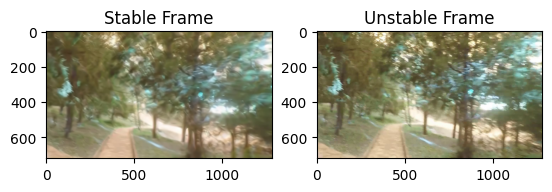

In [12]:
cap = cv2.VideoCapture('E:/Datasets/DeepStab_Modded/Stable_60/28.avi')
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
_,stable_frame = cap.read()
cap = cv2.VideoCapture('E:/Datasets/DeepStab_Modded/Unstable/28.avi')
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
_,unstable_frame = cap.read()
plt.subplot(1,2,1)
plt.imshow(stable_frame)
plt.title('Stable Frame')
plt.subplot(1,2,2)
plt.imshow(unstable_frame)
plt.title('Unstable Frame')

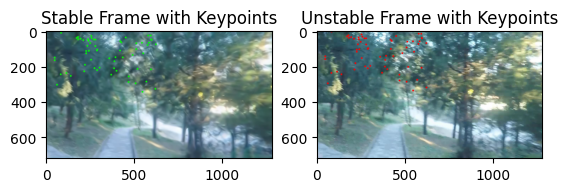

In [13]:
for point in stable_points:
    x,y = point
    cv2.circle(stable_frame, (int(x),int(y)), 5, (0, 255, 0), -1)  # Green circles for stable keypoints
for point in unstable_points:
    x,y = point
    cv2.circle(unstable_frame, (int(x),int(y)), 5, (0, 0, 255), -1)  # Red circles for unstable keypoints
# Plot the frames with keypoints
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(stable_frame, cv2.COLOR_BGR2RGB))
plt.title('Stable Frame with Keypoints')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(unstable_frame, cv2.COLOR_BGR2RGB))
plt.title('Unstable Frame with Keypoints')
plt.show()